In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
import japanize_matplotlib
import sys
import json

#CAEモデル呼び出し用のモジュール達
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import TensorDataset, DataLoader
from torchviz import make_dot
from torchsummary import summary


from sklearn.model_selection import train_test_split
sys.path.append("/home/cygnus/fujimoto/Cygnus-X_CAE/Cygnus-X_cloud/models")
from CAE import model_layer9_BatchNorm_no_center as model

import glob
import os
import time
import re
import wandb

In [40]:
from collections import Counter

def frequency_table(lst):
    """
    リストを度数分布表に変換し、出力する関数。
    """
    # Counterで要素ごとの出現回数をカウント
    counts = Counter(lst)
    
    # 度数分布表を作成して表示
    print("度数分布表:")
    for key, value in sorted(counts.items()):
        print(f"{key}: {value}個")

class DataSet():
    def __init__(self, data, label):
        self.label = label
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [34]:
api = wandb.Api()
artifact_path = 'yudai22-/condition_matching/training_log:v5'
artifact = api.artifact(artifact_path)

run = artifact.logged_by()


try:
    config_dict = json.loads(run.config)
    latent = config_dict["latent_num"]
    print(latent)
    latent = latent['value']
    print(latent)
except json.JSONDecodeError:
    # run.config が有効なJSON文字列でなかった場合の処理
    print("エラー: run.config は有効なJSON形式ではありません。")
except TypeError:
    # run.config が文字列でなかった場合の処理 (念のため)
    print("エラー: run.config は文字列型ではありません。")


# latent = run.config["latent_num"]
# print(latent)

match = re.findall('/.*/', artifact_path)
log_name = re.search(r"(training.*)", artifact_path).group()

print(log_name)
print(match[0][1:-1])

{'value': 100}
100
training_log:v5
condition_matching


In [33]:
print(latent['value'])

100


In [37]:
# api = wandb.Api()
# artifact_path = 'yudai22-/condition_matching/training_log:v5'
# artifact = api.artifact(artifact_path)
# artifact_dir = artifact.download()

# run = artifact.logged_by()
# latent = run.config["latent_num"]
# print(latent)

weight_path = f"{artifact_dir}/model_parameter.pth"
weight_para = torch.load(weight_path, map_location=torch.device('cpu'))

In [11]:
import re

match = re.findall('/.*/', artifact_path)
log_name = artifact_path.split("/")[-1]

print(log_name)
print(match[0][1:-1])

training_log:v5
condition_matching


In [19]:
all_region_latent = np.load(f"/home/cygnus/fujimoto/Cygnus-X_CAE/analysis/check_latent/latent_list/{match[0][1:-1]}/all/{log_name}_all_latent.npy")
bubble_region_latent = np.load(f"/home/cygnus/fujimoto/Cygnus-X_CAE/analysis/check_latent/latent_list/{match[0][1:-1]}/bubble/{log_name}_bubble_latent.npy")
view_all_region = np.load("/home/cygnus/fujimoto/Cygnus-X_CAE/data/zroing_resize_data/resize_data/condition_match/one_size/CygnusX_cut_one_size_mode_percentile_100x100.npy")
bubble = np.load("/home/cygnus/fujimoto/Cygnus-X_CAE/data/zroing_resize_data/resize_data/condition_match/vflip/CygnusX_bubble_vflip.npy")

In [20]:
all_plus_bubble_data = np.concatenate([view_all_region, bubble], axis=0)
all_plus_bubble_latent = np.concatenate([all_region_latent, bubble_region_latent])

In [21]:
sums = np.array([np.nansum(arr) for arr in bubble])
min_threshold = np.min(sums)
max_threshold = np.max(sums)

print("min_threshold", min_threshold)
print("max_threshold", max_threshold)

sums = np.array([np.nansum(arr) for arr in view_all_region])
top_quarter_arrays = [arr for arr, s in zip(all_region_latent, sums) if max_threshold >= s >= min_threshold]
print(len(top_quarter_arrays))

min_threshold 1938.8785969369821
max_threshold 54654.05291035144
1382


In [22]:
from Analysis_Tools.KS_sub import select_top, KS_test, sort_dict
# 上位分子雲強度が上位1/4であるデータの潜在変数からランダムに選択、もしくは全領域

In [23]:
all_bubble_KS = KS_test(np.array(top_quarter_arrays), bubble_region_latent)

Number of parameters with different distributions: 10


In [24]:
top_set = True  # True or False
random_times = 1000


different_list = []
print("\033[35m-形状比較-\033[0m")
print("全領域: ", all_region_latent.shape)
print("バブル領域", bubble_region_latent.shape, "\n")

dif_latent_list = []
for times in range(random_times):
    
    if top_set:
        if times == 0:
            print("平均値: ", np.nanmean(sums))
            # print("閾値: ", threshold)
                
        random_numbers = random.sample(range(0, len(top_quarter_arrays)), len(bubble_region_latent))
        random_numbers.sort()
        print("\n", f"\033[31m検証{times+1}回目\033[0m")
        print("\033[35mランダム番号：\033[0m\n", random_numbers)
        
        random_region_latent = np.array([top_quarter_arrays[i] for i in random_numbers])

        # random_numbers_02 = random.sample(range(0, len(top_quarter_arrays)), len(bubble_region_latent))
        # random_region_latent_02 = np.array([top_quarter_arrays[i] for i in random_numbers_02])
        
    else:
        random_numbers = random.sample(range(0, len(all_region_latent)), len(bubble_region_latent))
        random_numbers.sort()
        print("\n", f"\033[31m検証{times+1}回目\033[0m")
        print("\033[35mランダム番号：\033[0m\n", random_numbers)
        
        random_region_latent = np.array([all_region_latent[i] for i in random_numbers])
    
    # for idx, num in enumerate(random_numbers):
    #     data = no_norm_data[num]
    #     integ_data = np.nansum(data, axis=0)
        
    #     row = idx // 10
    #     col = idx % 10
        
    #     axes[row, col].imshow(integ_data)
    #     axes[row, col].axis("off")
    #     axes[row, col].set_title(f"cut_number{num}")
        
    # # 余分なaxesを非表示にする
    # for idx in range(len(random_numbers), 30):
    #     row = idx // 10
    #     col = idx % 10
    #     axes[row, col].axis("off")
    
    # plt.tight_layout()
    # plt.savefig(f"random_{times}.png")

    
    dif_dic = KS_test(bubble_region_latent, random_region_latent)##ここ重要！！
    different_list.append(len(dif_dic.items()))
    dif_latent_list += list(dif_dic.keys())
    print("different latent num is ", list(dif_dic.keys()))
    
print("\n", f"different_value: {different_list}")
print(f"mean: {np.mean(different_list)}")
frequency_table(dif_latent_list)

-形状比較-
全領域:  (1389, 100)
バブル領域 (31, 100) 

平均値:  13904.513287902264

 検証1回目
ランダム番号：
 [56, 64, 182, 294, 404, 413, 490, 518, 536, 625, 641, 656, 705, 706, 719, 741, 762, 832, 893, 1073, 1101, 1134, 1137, 1162, 1231, 1284, 1287, 1333, 1340, 1358, 1362]
Number of parameters with different distributions: 1
different latent num is  [63]

 検証2回目
ランダム番号：
 [6, 8, 10, 20, 71, 138, 173, 211, 299, 344, 345, 348, 411, 433, 494, 519, 674, 683, 822, 827, 911, 934, 970, 1038, 1098, 1128, 1196, 1262, 1274, 1306, 1342]
Number of parameters with different distributions: 0
different latent num is  []

 検証3回目
ランダム番号：
 [10, 68, 143, 155, 192, 196, 239, 255, 291, 338, 371, 404, 406, 448, 488, 523, 554, 581, 594, 827, 828, 857, 888, 903, 912, 915, 927, 1012, 1049, 1113, 1250]
Number of parameters with different distributions: 0
different latent num is  []

 検証4回目
ランダム番号：
 [5, 62, 116, 181, 218, 371, 386, 424, 440, 562, 593, 624, 639, 705, 711, 712, 719, 781, 823, 935, 977, 1021, 1049, 1076, 1077, 1134, 1145,

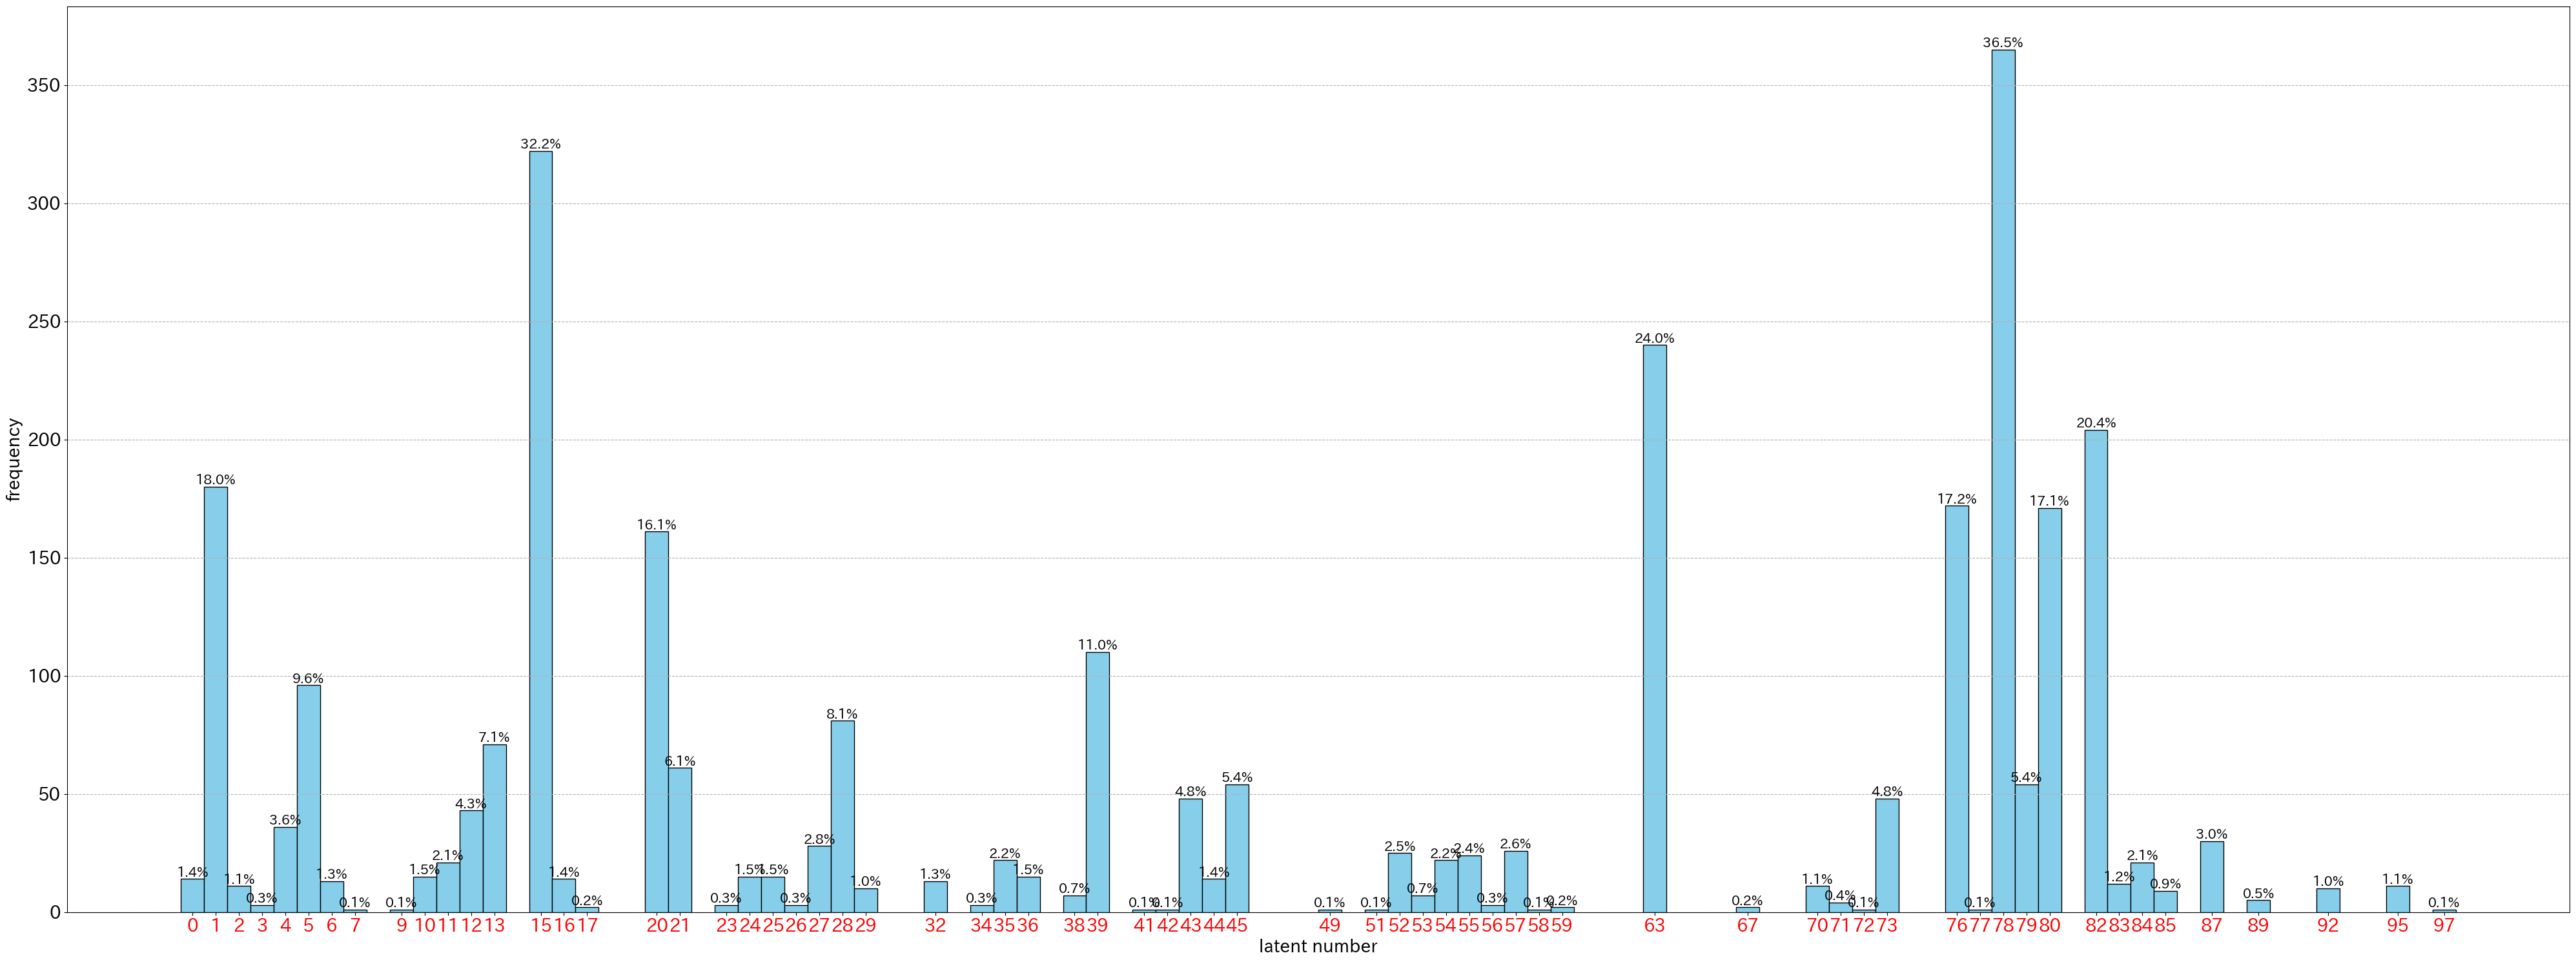

In [25]:
from collections import Counter
import matplotlib.pyplot as plt

# 度数分布の計算
count_hist = Counter(dif_latent_list)

keys = sorted(count_hist.keys())
values = [count_hist[key] for key in keys]

# グラフの描画
plt.figure(figsize=(40, 15))
bars = plt.bar(keys, values, color="skyblue", edgecolor="k", width=1)

# 棒の上に対応するx軸の値を描画
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),  # 棒の中央上部に配置
             f"{'{:.1f}'.format(value/random_times*100)}%", ha='center', va='bottom', fontsize=15)

# ラベルとグリッド
plt.xticks(keys, color="red", fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("latent number", fontsize=20)
plt.ylabel("frequency", fontsize=20)
plt.grid(axis="y", linestyle="--")

# レイアウト調整
plt.tight_layout()
plt.savefig(f"dif_latent_bar_{match[0][1:-1]}_{log_name}")
plt.show()

In [26]:
print(f"データの形状:\n 全領域➡{all_region_latent.shape} \nバブル領域➡{bubble_region_latent.shape}")

データの形状:
 全領域➡(1389, 100) 
バブル領域➡(31, 100)


In [27]:
dif_count = Counter(dif_latent_list)
print(dif_count)

Counter({78: 365, 15: 322, 63: 240, 82: 204, 1: 180, 76: 172, 80: 171, 20: 161, 39: 110, 5: 96, 28: 81, 13: 71, 21: 61, 79: 54, 45: 54, 73: 48, 43: 48, 12: 43, 4: 36, 87: 30, 27: 28, 57: 26, 52: 25, 55: 24, 35: 22, 54: 22, 84: 21, 11: 21, 36: 15, 25: 15, 24: 15, 10: 15, 44: 14, 0: 14, 16: 14, 6: 13, 32: 13, 83: 12, 70: 11, 2: 11, 95: 11, 92: 10, 29: 10, 85: 9, 53: 7, 38: 7, 89: 5, 71: 4, 34: 3, 26: 3, 56: 3, 3: 3, 23: 3, 17: 2, 59: 2, 67: 2, 41: 1, 42: 1, 97: 1, 58: 1, 51: 1, 72: 1, 49: 1, 77: 1, 7: 1, 9: 1})


In [28]:
max(dif_count.values())

365

In [35]:
sorted_keys = [k for k, v in sorted(dif_count.items(), key=lambda item: item[1], reverse=True)]
set_sorted = set(sorted_keys)
top_keys = sorted_keys[:5]
all_numbers = set(range(latent))
missing_numbers = list(all_numbers - set_sorted)
bottom_keys = sorted(missing_numbers)
print(top_keys)
print(bottom_keys)

[78, 15, 63, 82, 1]
[8, 14, 18, 19, 22, 30, 31, 33, 37, 40, 46, 47, 48, 50, 60, 61, 62, 64, 65, 66, 68, 69, 74, 75, 81, 86, 88, 90, 91, 93, 94, 96, 98, 99]


In [41]:
model = model.Conv3dAutoencoder(latent)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

model.load_state_dict(weight_para)
model.to(device)

model.eval()

Conv3dAutoencoder(
  (encoder): Sequential(
    (0): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(32, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (10): ReLU(inplace=True)
    (11): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (12): ReLU(inplace=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=84640, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): 

In [42]:
summary(model.to(device), (1, 30, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 15, 50, 50]           2,080
       BatchNorm3d-2       [-1, 32, 15, 50, 50]              64
              ReLU-3       [-1, 32, 15, 50, 50]               0
            Conv3d-4        [-1, 32, 7, 25, 25]          65,568
       BatchNorm3d-5        [-1, 32, 7, 25, 25]              64
              ReLU-6        [-1, 32, 7, 25, 25]               0
            Conv3d-7        [-1, 64, 7, 25, 25]          55,360
       BatchNorm3d-8        [-1, 64, 7, 25, 25]             128
              ReLU-9        [-1, 64, 7, 25, 25]               0
           Conv3d-10        [-1, 64, 7, 25, 25]         110,656
             ReLU-11        [-1, 64, 7, 25, 25]               0
           Conv3d-12        [-1, 32, 5, 23, 23]          55,328
             ReLU-13        [-1, 32, 5, 23, 23]               0
          Flatten-14                [-1

In [43]:
#特定のインデックスの数字の範囲を確かめる
print("\033[35m- 上位5つの全データの潜在変数の最大及び最小値\033[0m")
for i, index in enumerate(top_keys):
    print(f"Top{i+1} range(index={index}) => {'{:.3f}'.format(np.min(all_plus_bubble_latent[:, index]))} ~ {'{:.3f}'.format(np.max(all_plus_bubble_latent[:, index]))}")
    
print("\n")
    
#特定のインデックスの全領域とバブル領域の潜在変数の平均値を確かめる
print("\033[35m- 上位5つの潜在変数の平均値\033[0m")
for i, index in enumerate(top_keys):
    print(f"Top{i+1} mean(index={index}) => 全領域: {'{:.3f}'.format(np.mean(all_plus_bubble_latent[:, index]))} , バブル領域: {'{:.3f}'.format(np.mean(bubble_region_latent[:, index]))}, 差(絶対値): {'{:.3f}'.format(abs(np.mean(all_plus_bubble_latent[:, index])-np.mean(bubble_region_latent[:, index])))}")

- 上位5つの全データの潜在変数の最大及び最小値
Top1 range(index=78) => -1.968 ~ 1.189
Top2 range(index=15) => -1.912 ~ 2.158
Top3 range(index=63) => -1.567 ~ 1.470
Top4 range(index=82) => -1.270 ~ 1.473
Top5 range(index=1) => -1.432 ~ 1.772


- 上位5つの潜在変数の平均値
Top1 mean(index=78) => 全領域: 0.052 , バブル領域: -0.166, 差(絶対値): 0.218
Top2 mean(index=15) => 全領域: -0.057 , バブル領域: 0.170, 差(絶対値): 0.227
Top3 mean(index=63) => 全領域: 0.021 , バブル領域: 0.130, 差(絶対値): 0.110
Top4 mean(index=82) => 全領域: 0.022 , バブル領域: 0.171, 差(絶対値): 0.149
Top5 mean(index=1) => 全領域: -0.103 , バブル領域: 0.065, 差(絶対値): 0.167


In [44]:
#特定のインデックスの数字の範囲を確かめる
print("\033[35m- 下位5つの全データの潜在変数の最大及び最小値\033[0m")
for i, index in enumerate(bottom_keys):
    print(f"Bottom{i+1} range(index={index}) => {'{:.3f}'.format(np.min(all_plus_bubble_latent[:, index]))} ~ {'{:.3f}'.format(np.max(all_plus_bubble_latent[:, index]))}")
    
print("\n")
    
#特定のインデックスの全領域とバブル領域の潜在変数の平均値を確かめる
print("\033[35m- 下位5つの潜在変数の平均値\033[0m")
for i, index in enumerate(bottom_keys):
    print(f"Bottom{i+1} mean(index={index}) => 全領域: {'{:.3f}'.format(np.mean(all_plus_bubble_latent[:, index]))} , バブル領域: {'{:.3f}'.format(np.mean(bubble_region_latent[:, index]))}, 差(絶対値): {'{:.3f}'.format(abs(np.mean(all_plus_bubble_latent[:, index])-np.mean(bubble_region_latent[:, index])))}")

- 下位5つの全データの潜在変数の最大及び最小値
Bottom1 range(index=8) => -1.299 ~ 1.470
Bottom2 range(index=14) => -1.530 ~ 1.204
Bottom3 range(index=18) => -1.522 ~ 1.388
Bottom4 range(index=19) => -2.467 ~ 2.188
Bottom5 range(index=22) => -1.794 ~ 1.385
Bottom6 range(index=30) => -1.829 ~ 1.365
Bottom7 range(index=31) => -1.531 ~ 2.023
Bottom8 range(index=33) => -1.527 ~ 1.847
Bottom9 range(index=37) => -1.191 ~ 1.893
Bottom10 range(index=40) => -1.307 ~ 1.106
Bottom11 range(index=46) => -1.442 ~ 1.708
Bottom12 range(index=47) => -1.186 ~ 1.682
Bottom13 range(index=48) => -1.811 ~ 1.384
Bottom14 range(index=50) => -1.297 ~ 1.214
Bottom15 range(index=60) => -1.730 ~ 1.111
Bottom16 range(index=61) => -1.794 ~ 1.388
Bottom17 range(index=62) => -1.900 ~ 1.679
Bottom18 range(index=64) => -1.227 ~ 1.501
Bottom19 range(index=65) => -1.354 ~ 1.392
Bottom20 range(index=66) => -2.142 ~ 1.596
Bottom21 range(index=68) => -1.090 ~ 1.620
Bottom22 range(index=69) => -2.361 ~ 1.261
Bottom23 range(index=74) => -2.434 ~ 1.

In [20]:
print(top_keys)

[58, 12, 81, 25, 33]


In [23]:
latent_index = 94
values = all_plus_bubble_latent[:, latent_index]
    
# トップ5とワースト5のインデックスを取得
top5_idx = np.argpartition(values, -5)[-5:]
worst5_idx = np.argpartition(values, 5)[:5]
print(top5_idx)
print(worst5_idx)

[6299 1101 7642 7593 7687]
[6795 1390  226 7033 4171]


In [24]:
all_plus_bubble_latent.shape

(7956, 100)

In [25]:
import numpy as np

arr = np.array(all_plus_bubble_latent[:, 94])

# 0に最も近い値のインデックスを取得
center_idx = np.argmin(np.abs(arr))

# 基準値
center_value = arr[center_idx]

# 基準値より大きい値のインデックス
bigger_indices = np.where(arr > center_value)[0]
# 基準値より小さい値のインデックス
smaller_indices = np.where(arr < center_value)[0]

# 基準値からの距離でソート
bigger_sorted = bigger_indices[np.argsort(np.abs(arr[bigger_indices] - center_value))]
smaller_sorted = smaller_indices[np.argsort(np.abs(arr[smaller_indices] - center_value))]

# 5つずつ取得
bigger_five = bigger_sorted[:5]
smaller_five = smaller_sorted[:5]

print("基準値(0に最も近い値):", center_value, "インデックス:", center_idx)
print("大きい方5つのインデックス:", bigger_five, "値:", arr[bigger_five])
print("小さい方5つのインデックス:", smaller_five, "値:", arr[smaller_five])

基準値(0に最も近い値): -7.992983e-05 インデックス: 2168
大きい方5つのインデックス: [3871 2171 5885 7024 2981] 値: [0.00012258 0.00078902 0.00094759 0.00204394 0.00220273]
小さい方5つのインデックス: [2562 4941  871 3436 2912] 値: [-0.00029772 -0.00141674 -0.00143686 -0.00204163 -0.00209487]


In [26]:
center_offsets = list(range(-50, 0, 10)) + [0] + list(range(10, 51, 10))  # -50, -40, ... 0, +10, ... +50
print(center_offsets)

[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]


In [16]:
RED = '\033[31m'
END = '\033[0m'

def make_filename(latent_index, label_type, rank_or_offset, idx, allch=False):
    """
    ファイル名を指定フォーマットで返す
    label_type: 'top', 'worst', 'center'
    rank_or_offset: int (順位または±オフセット)
    idx: インデックス
    allch: Trueなら_allchをつける
    """
    base = f"latent{latent_index}_{label_type}{rank_or_offset:+d}_No{idx}" if label_type == 'center' \
        else f"latent{latent_index}_{label_type}{rank_or_offset}_No{idx}"
    if allch:
        base += "_allch"
    return base + ".png"

top_ranks = [1, 20, 40, 60, 80, 100]  # 1-based
worst_ranks = [1, 20, 40, 60, 80, 100]  # 1-based
center_offsets = [-50, -30, -10, 0, 10, 30, 50]

for latent_index in top_keys:
    print(RED + f"latent: {latent_index}" + END)
    values = all_plus_bubble_latent[:, latent_index]
    
    # --- Top / Worst の部分は変更なし ---
    # Top: 値が大きい順
    sorted_desc_idx = np.argsort(values)[::-1]  # 降順
    for rank in top_ranks:
        if rank-1 >= len(sorted_desc_idx):
            continue
        idx = sorted_desc_idx[rank-1]
        value = values[idx]
        label_text = f"Top {rank}: No.{idx}, value: {value:.3f}"
        arg_data = all_plus_bubble_data[idx]
        filename = make_filename(latent_index, "top", rank, idx)
        plt.figure()
        plt.imshow(np.sum(arg_data, axis=0), vmin=0, vmax=5, cmap="jet")
        plt.axis("off")
        plt.title(label_text, fontsize=15, color="k")
        plt.savefig(filename, bbox_inches="tight")
        plt.show()
        
        fig, axes = plt.subplots(1, len(arg_data), figsize=(3*len(arg_data), 5))
        for j, data in enumerate(arg_data):
            axes[j].imshow(data, cmap="jet", vmin=0, vmax=1)
            axes[j].axis("off")
        fig.suptitle(label_text, fontsize=40, color="k")
        plt.tight_layout()
        filename_allch = make_filename(latent_index, "top", rank, idx, allch=True)
        plt.savefig(filename_allch, bbox_inches="tight")
        plt.show()
        print("\n")
    
    # Worst: 値が小さい順
    sorted_asc_idx = np.argsort(values)  # 昇順
    for rank in worst_ranks:
        if rank-1 >= len(sorted_asc_idx):
            continue
        idx = sorted_asc_idx[rank-1]
        value = values[idx]
        label_text = f"Worst {rank}: No.{idx}, value: {value:.3f}"
        arg_data = all_plus_bubble_data[idx]
        filename = make_filename(latent_index, "worst", rank, idx)
        plt.figure()
        plt.imshow(np.sum(arg_data, axis=0), vmin=0, vmax=5, cmap="jet")
        plt.axis("off")
        plt.title(label_text, fontsize=15, color="k")
        plt.savefig(filename, bbox_inches="tight")
        plt.show()
        
        fig, axes = plt.subplots(1, len(arg_data), figsize=(3*len(arg_data), 5))
        for j, data in enumerate(arg_data):
            axes[j].imshow(data, cmap="jet", vmin=0, vmax=1)
            axes[j].axis("off")
        fig.suptitle(label_text, fontsize=40, color="k")
        plt.tight_layout()
        filename_allch = make_filename(latent_index, "worst", rank, idx, allch=True)
        plt.savefig(filename_allch, bbox_inches="tight")
        plt.show()
        print("\n")

    # --- Center: 0に一番近いものを基準に±10ずつ±50まで ---
    arr = values
    
    # 正の値のインデックスと負の値のインデックスを分離
    # ここでのインデックスは元の配列 (arr) のインデックスです。
    positive_original_indices = np.where(arr >= 0)[0] # 0も正に含める
    negative_original_indices = np.where(arr < 0)[0]

    # それぞれのグループ内で絶対値が小さい順にソート（元のインデックスを保持）
    # 例: positive_original_indices = [10, 5, 20], arr[10]=0.01, arr[5]=0.05, arr[20]=0.005
    # np.argsort(arr[positive_original_indices]) は [2, 0, 1] (元のインデックス20, 10, 5に対応)
    # これを positive_original_indices[ソートされたインデックス] に適用すると
    # [20, 10, 5] となり、元のインデックスが値の昇順にソートされます。
    sorted_positive_abs_idx = positive_original_indices[np.argsort(arr[positive_original_indices])]
    
    # 負の値については、絶対値でソートします。
    # 例: negative_original_indices = [30, 40, 50], arr[30]=-0.05, arr[40]=-0.01, arr[50]=-0.005
    # np.abs(arr[negative_original_indices]) は [0.05, 0.01, 0.005]
    # np.argsort(...) は [2, 1, 0] (元のインデックス50, 40, 30に対応)
    # sorted_negative_abs_idx は [50, 40, 30] となり、元のインデックスが絶対値の昇順（0に近い順）にソートされます。
    sorted_negative_abs_idx = negative_original_indices[np.argsort(np.abs(arr[negative_original_indices]))]
    
    for offset in center_offsets:
        idx = -1 # 初期化
        label = ""
        
        if offset == 0:
            # 0に最も近い値を検索（正負を問わず）。これは常に単一の最も近い値。
            closest_idx = np.argmin(np.abs(arr))
            idx = closest_idx
            label = "Center 0 (closest to 0)"
            
        elif offset > 0:
            # 正のオフセット: 0に最も近い正の値から数える (1-based rank)。
            # 例: offset=10 は、0に最も近い正の値から10番目の正の値。
            # リストのインデックスは0から始まるため、rank-1 を使用。
            rank_to_select = offset 
            if rank_to_select - 1 < len(sorted_positive_abs_idx):
                idx = sorted_positive_abs_idx[rank_to_select - 1]
                label = f"Center +{offset}"
            else:
                print(f"Skipping latent {latent_index}, offset +{offset}: Not enough positive values close to 0.")
                continue # 次のオフセットへ
                
        else: # offset < 0
            # 負のオフセット: 0に最も近い負の値から数える (1-based rank)。
            # 例: offset=-10 は、0に最も近い負の値から10番目の負の値。
            # リストのインデックスは0から始まるため、abs(offset)-1 を使用。
            rank_to_select = abs(offset) 
            if rank_to_select - 1 < len(sorted_negative_abs_idx):
                idx = sorted_negative_abs_idx[rank_to_select - 1]
                label = f"Center {offset}"
            else:
                print(f"Skipping latent {latent_index}, offset {offset}: Not enough negative values close to 0.")
                continue # 次のオフセットへ

        if idx != -1: # 有効なインデックスが選択された場合のみ処理
            value = values[idx]
            label_text = f"{label}: No.{idx}, value: {value:.5f}"
            arg_data = all_plus_bubble_data[idx]
            filename = make_filename(latent_index, "center", offset, idx)
            
            plt.figure()
            plt.imshow(np.sum(arg_data, axis=0), vmin=0, vmax=5, cmap="jet")
            plt.axis("off")
            plt.title(label_text, fontsize=15, color="k")
            plt.savefig(filename, bbox_inches="tight")
            plt.show()
            
            fig, axes = plt.subplots(1, len(arg_data), figsize=(3*len(arg_data), 5))
            for j, data in enumerate(arg_data):
                axes[j].imshow(data, cmap="jet", vmin=0, vmax=1)
                axes[j].axis("off")
            fig.suptitle(label_text, fontsize=40, color="k")
            plt.tight_layout()
            filename_allch = make_filename(latent_index, "center", offset, idx, allch=True)
            plt.savefig(filename_allch, bbox_inches="tight")
            plt.show()
            print("\n")

In [18]:
#特定のインデックスの数字の範囲を確かめる
print("\033[35m-異なった回数がゼロの全データの潜在変数の最大及び最小値-\033[0m")
for i, index in enumerate(bottom_keys):
    print(f"Bottom{i+1} range(index={index}) => {'{:.3f}'.format(np.min(all_plus_bubble_latent[:, index]))} ~ {'{:.3f}'.format(np.max(all_plus_bubble_latent[:, index]))}")
    
print("\n")

#特定のインデックスの全領域とバブル領域の潜在変数の平均値を確かめる
print("\033[35m-異なった回数がゼロの下位5つの潜在変数の平均値-\033[0m")
for i, index in enumerate(bottom_keys):
    print(f"Bottom{i+1} mean(index={index}) => 全領域: {'{:.3f}'.format(np.mean(all_plus_bubble_latent[:, index]))} , バブル領域: {'{:.3f}'.format(np.mean(bubble_region_latent[:, index]))}, 差(絶対値): {'{:.3f}'.format(abs(np.mean(all_plus_bubble_latent[:, index])-np.mean(bubble_region_latent[:, index])))}")

In [24]:
# # bubble_num = 26
# for bubble_num, select_bubble_latent in enumerate(bubble_region_latent):    
#     select_latent = [val if i in top_keys else 0 for i, val in enumerate(select_bubble_latent)]
#     select_latent = torch.tensor(select_latent).to(device)
#     select_latent = select_latent.reshape(1, latent)
#     # print(select_latent.shape)
#     # print(select_latent)
    
#     with torch.no_grad():
#         generated_image = model.decoder(select_latent)
    
#     # 生成した画像をnumpy配列に変換
#     generated_image_np = generated_image.cpu().numpy()
#     generated_image_np = generated_image_np.squeeze()
    
#     fig, axes = plt.subplots(2, len(generated_image_np), figsize=(len(generated_image_np)*3, 2*3))
#     for i in range(len(generated_image_np)):
#         axes[0, i].imshow(bubble[bubble_num][i])
#         axes[0, i].axis("off")
    
#         axes[1, i].imshow(generated_image_np[i])
#         axes[1, i].axis("off")
    
#     fig.suptitle(f"bubble_number{bubble_num+1}", x=0.5, y=0.98, ha='left', fontsize=20, color="r")
#     plt.tight_layout()
#     # if bubble_num < 9:
#     #     plt.savefig(f"CynusX_bubble_latent{latent}_dif_All_No0{bubble_num+1}")
#     # else:
#     #     plt.savefig(f"CynusX_bubble_latent{latent}_dif_All_No{bubble_num+1}")
#     plt.show()

In [17]:
for top, any_value in enumerate(top_keys):
    latent_range = np.arange(-2, 2.1, 0.5)
    latent_test = torch.zeros(1, latent).to(device)
    print(latent_test.shape)
    
    fig, axes = plt.subplots(len(np.arange(-2, 2.1, 0.5)), 30, figsize=(3*30, 3*len(np.arange(-2, 2.1, 0.5))))
    for latent_value in range(len(latent_range)):
        latent_test[0, any_value] = latent_range[latent_value]
    
        with torch.no_grad():
            generated_image = model.decoder(latent_test)
    
        # 生成した画像をnumpy配列に変換
        generated_image_np = generated_image.cpu().numpy()
        generated_image_np = generated_image_np.squeeze() 
    
        for j in range(len(generated_image_np)):
            axes[latent_value, j].imshow(generated_image_np[j], vmin=0, vmax=1)
            axes[latent_value, j].axis("off")
    
        axes[latent_value, 0].text(-10, 56, f'{latent_range[latent_value]}', fontsize=30, ha='right')
        
    fig.suptitle(f"latent No.{any_value}", fontsize=50)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.savefig(f"Dif_latent_top{top+1}.png", dpi=80)
    plt.show()

In [19]:
#適当な潜在変数の値を-10から10に変化させてみる

any_value = 0
latent_range = np.arange(-2, 2.1, 0.5)
latent_test = torch.zeros(1, latent).to(device)
print(latent_test.shape)

fig, axes = plt.subplots(len(np.arange(-2, 2.1, 0.5)), 30, figsize=(3*30, 3*len(np.arange(-2, 2.1, 0.5))))
for latent_value in range(len(latent_range)):
    latent_test[0, any_value] = latent_range[latent_value]

    with torch.no_grad():
        generated_image = model.decoder(latent_test)

    # 生成した画像をnumpy配列に変換
    generated_image_np = generated_image.cpu().numpy()
    generated_image_np = generated_image_np.squeeze() 

    for j in range(len(generated_image_np)):
        axes[latent_value, j].imshow(generated_image_np[j], vmin=0, vmax=1)
        axes[latent_value, j].axis("off")

    axes[latent_value, 0].text(-10, 56, f'{latent_range[latent_value]}', fontsize=30, ha='right')
    
fig.suptitle(f"No.{any_value}", fontsize=50)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(f"Non_Dif_latent_No_{any_value}.png", dpi=80)
plt.show()

-上位5つの全データの潜在変数の最大及び最小値-


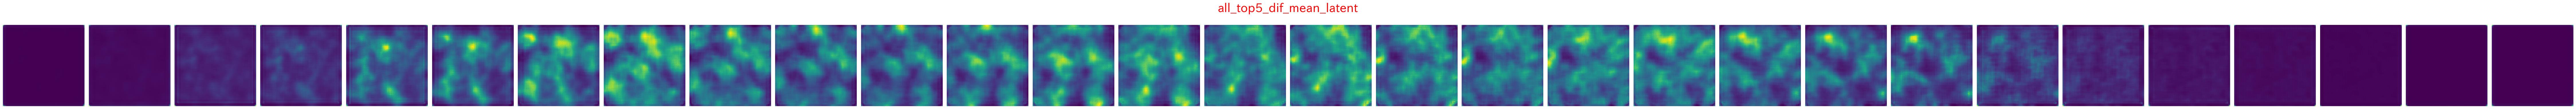

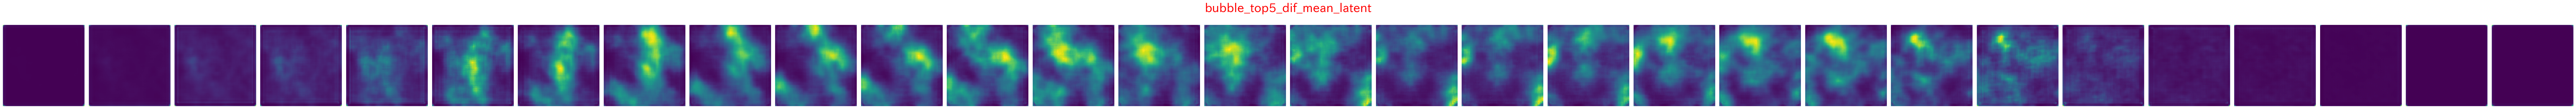

In [31]:
print("\033[35m-上位5つの全データの潜在変数の最大及び最小値-\033[0m")

all_test = np.zeros((1, latent))
bubble_test = np.zeros((1, latent))

for i, index in enumerate(top_keys):
    all_mean = np.mean(all_region_latent[:, index])
    bubble_mean = np.mean(bubble_region_latent[:, index])

    all_test[0, index] = all_mean
    bubble_test[0, index] = bubble_mean

# print(all_test)
# print(bubble_test)

for latent_test in [all_test, bubble_test]:
    if np.array_equal(latent_test, all_test):
        title = "all_top5_dif_mean_latent"
    elif np.array_equal(latent_test, bubble_test):
        title = "bubble_top5_dif_mean_latent"
        
    fig, axes = plt.subplots(1, 30, figsize=(3*30, 4*1))
    latent_test = torch.from_numpy(latent_test).float()
    latent_test = latent_test.to(device)

    # print(latent_test)
    with torch.no_grad():
        generated_image = model.decoder(latent_test)
    
    # 生成した画像をnumpy配列に変換
    generated_image_np = generated_image.cpu().numpy()
    generated_image_np = generated_image_np.squeeze() 
    
    for j in range(len(generated_image_np)):
        axes[j].imshow(generated_image_np[j])
        axes[j].axis("off")
    
    # axes[j].text(-10, 56, f'{latent_range[latent_value]}', fontsize=30, ha='right')
    
    fig.suptitle(title, fontsize=30, color="red")
    plt.tight_layout()
    # plt.subplots_adjust(top=0.95)
    plt.savefig(title)
    plt.show()

In [20]:
#適当な潜在変数の値を-10から10に変化させてみる
any_value = 7
latent_range = np.arange(-30, 30, 5)
latent_test = torch.zeros(1, latent).to(device)
print(latent_test.shape)

fig, axes = plt.subplots(len(np.arange(-30, 30, 5)), 30, figsize=(3*30, 3*len(np.arange(-30, 30, 5))))
for latent_value in range(len(latent_range)):
    latent_test[0, any_value] = latent_range[latent_value]
    
    with torch.no_grad():
        generated_image = model.decoder(latent_test)
    
    # 生成した画像をnumpy配列に変換
    generated_image_np = generated_image.cpu().numpy()
    generated_image_np = generated_image_np.squeeze() 
    
    for j in range(len(generated_image_np)):
        axes[latent_value, j].imshow(generated_image_np[j])
        axes[latent_value, j].axis("off")
    
    axes[latent_value, 0].text(-10, 56, f'{latent_range[latent_value]}', fontsize=30, ha='right')
    
fig.suptitle(f"No.{any_value}", fontsize=50)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.savefig(f"Non_Dif_latent_No_{any_value}.png", dpi=80)
plt.show()

In [33]:
trancation_bubble = np.load("/home/filament/fujimoto/Cygnus-X_CAE/data/zroing_resize_data/resize_data/ truncation/CygnusX_cut_truncation_resize_bubble_to_100x100.npy")